In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import sem
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as colors
from venn import venn, pseudovenn
import seaborn as sns
from Bio import SeqIO, SeqUtils
from addict import Dict
import math
import seaborn as sns

sys.path.append("../")
import plotting as my_plot

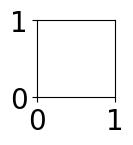

In [4]:
fig, ax = my_plot.instantiate_fig(1, 1)

In [15]:
df_master = pd.read_csv('./generated_tables/location_master_with_only_mean_properties.csv')

In [16]:
df_master.rename(columns={'std_hccf_feed':'Standard HCCF Feed', 'std_hccf_large':'Standard HCCF Large agg.', 'std_hccf_small':'Standard HCCF Small agg.', 
                          'std_hccf_mab':'Standard HCCF mAb', 'std_hccf_lmw1':'Standard HCCF SPF 1', 'std_hccf_lmw2':'Standard HCCF SPF 2', 
                          'native_hccf_feed':'Native HCCF Feed', 'native_hccf_large':'Native HCCF Large agg.', 'native_hccf_small':'Native HCCF Small agg.', 
                          'native_hccf_mab':'Native HCCF mAb', 'native_hccf_lmw1':'Native HCCF SPF 1', 
                          'std_pafvin_feed':'Standard PAVIN Feed', 'std_pafvin_large':'Standard PAVIN Large agg.', 'std_pafvin_small':'Standard PAVIN Small agg.', 
                          'std_pafvin_mab':'Standard PAVIN mAb', 
                          'native_pafvin_feed':'Native PAVIN Feed', 'native_pafvin_large':'Native PAVIN Large agg.', 'native_pafvin_small':'Native PAVIN Small agg.', 
                          'native_pafvin_mab':'Native PAVIN mAb',                        
                          'pI_mean':'pI', 'cysteine_cont_percent_mean':'Cysteine content [%]',
                           'cysteine_num_mean':'Cysteine residues'}, inplace=True)

In [17]:
df_locs = df_master[['Native HCCF Feed', 'Standard HCCF Feed', 'Native HCCF Large agg.', 'Standard HCCF Large agg.', 
                     'Native HCCF Small agg.', 'Standard HCCF Small agg.', 'Native HCCF mAb', 'Standard HCCF mAb', 
                     'Native HCCF SPF 1', 'Standard HCCF SPF 1', 'Standard HCCF SPF 2',                       
                     'Native PAVIN Feed', 'Standard PAVIN Feed', 'Native PAVIN Large agg.', 'Standard PAVIN Large agg.', 
                     'Native PAVIN Small agg.', 'Standard PAVIN Small agg.', 'Native PAVIN mAb', 'Standard PAVIN mAb', 'name']]

for i, cont in df_locs.iterrows():
    name = cont['name']
    df_locs.at[i, 'name'] = name[:1].upper() + name[1:-21]
df_locs.set_index('name', inplace=True)

for i, cont in df_master.iterrows():
    name = cont['name']
    df_master.at[i, 'name'] = name[:1].upper() + name[1:-21]
df_master.set_index('name', inplace=True)

df_locs_native = df_locs[[c for c in df_locs.columns if 'Native' in c]].copy()
df_locs_std = df_locs[[c for c in df_locs.columns if 'Standard' in c]].copy()

for c in df_locs_native.columns:
    df_locs_native[c] = df_locs_native[c].map({False:0, True:1})
    
for c in df_locs_std.columns:
    df_locs_std[c] = df_locs_std[c].map({False:0, True:0.5})
    
df_locs_2 = df_locs_native.merge(df_locs_std, left_index=True, right_index=True)

df_locs_2 = df_locs_2[['Native HCCF Feed', 'Standard HCCF Feed', 'Native HCCF Large agg.', 'Standard HCCF Large agg.', 
                     'Native HCCF Small agg.', 'Standard HCCF Small agg.', 'Native HCCF mAb', 'Standard HCCF mAb', 
                     'Native HCCF SPF 1', 'Standard HCCF SPF 1', 'Standard HCCF SPF 2',                       
                     'Native PAVIN Feed', 'Standard PAVIN Feed', 'Native PAVIN Large agg.', 'Standard PAVIN Large agg.', 
                     'Native PAVIN Small agg.', 'Standard PAVIN Small agg.', 'Native PAVIN mAb', 'Standard PAVIN mAb']]

In [18]:
cmap_cluster = matplotlib.colors.ListedColormap(['white', 'tab:orange', 'tab:blue'])
norm_cluster = BoundaryNorm([0, 0.25, 0.75, 1], cmap_cluster.N)

series = df_master['pI']
cmap = plt.get_cmap('jet')
norm = plt.Normalize(series.min(), series.max())
row_colors1 = cmap(norm(series))

series2 = df_master['Cysteine content [%]']
cmap2 = plt.get_cmap('bwr')
norm2 = colors.SymLogNorm(3.0)
row_colors2 = cmap2(norm2(series2))

row_colors = pd.concat([pd.Series(row_colors1.tolist(), index=df_master.index, name='pI'), 
                        pd.Series(row_colors2.tolist(), index=df_master.index, name='Cysteine content')], axis=1)

In [19]:
df_locs_2

,Native HCCF Feed,Standard HCCF Feed,Native HCCF Large agg.,Standard HCCF Large agg.,Native HCCF Small agg.,Standard HCCF Small agg.,Native HCCF mAb,Standard HCCF mAb,Native HCCF SPF 1,Standard HCCF SPF 1,Standard HCCF SPF 2,Native PAVIN Feed,Standard PAVIN Feed,Native PAVIN Large agg.,Standard PAVIN Large agg.,Native PAVIN Small agg.,Standard PAVIN Small agg.,Native PAVIN mAb,Standard PAVIN mAb
name,,,,,,,,,,,,,,,,,,,
Neuroblast differentiation-associated protein AHNAK isoform X23,1,0.5,1,0.5,1,0.5,1,0.0,1,0.5,0.5,0,0.0,0,0.0,0,0.0,0,0.0
Plectin isoform X6,1,0.5,1,0.5,1,0.5,1,0.5,1,0.5,0.5,0,0.0,1,0.5,1,0.0,0,0.0
Endoplasmic reticulum chaperone BiP precursor,1,0.5,1,0.5,1,0.5,1,0.5,1,0.5,0.5,1,0.5,1,0.5,1,0.5,0,0.0
Inter-alpha-trypsin inhibitor heavy chain H5 isoform X2,1,0.5,1,0.5,1,0.5,1,0.5,1,0.5,0.5,0,0.0,1,0.5,1,0.0,0,0.0
Filamin-B isoform X3,1,0.5,1,0.5,1,0.5,1,0.0,1,0.5,0.5,0,0.0,1,0.5,1,0.5,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Elongation factor 1-alpha 1,1,0.5,1,0.5,1,0.5,1,0.5,1,0.5,0.5,1,0.5,1,0.5,1,0.5,0,0.0
"10 kDa heat shock protein, mitochondrial",1,0.5,0,0.0,0,0.0,0,0.0,1,0.5,0.5,0,0.0,0,0.0,0,0.0,0,0.0
Beta-hexosaminidase subunit beta isoform X2,1,0.0,1,0.5,1,0.5,1,0.0,1,0.0,0.0,0,0.0,1,0.5,1,0.0,0,0.0


/home/chase/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


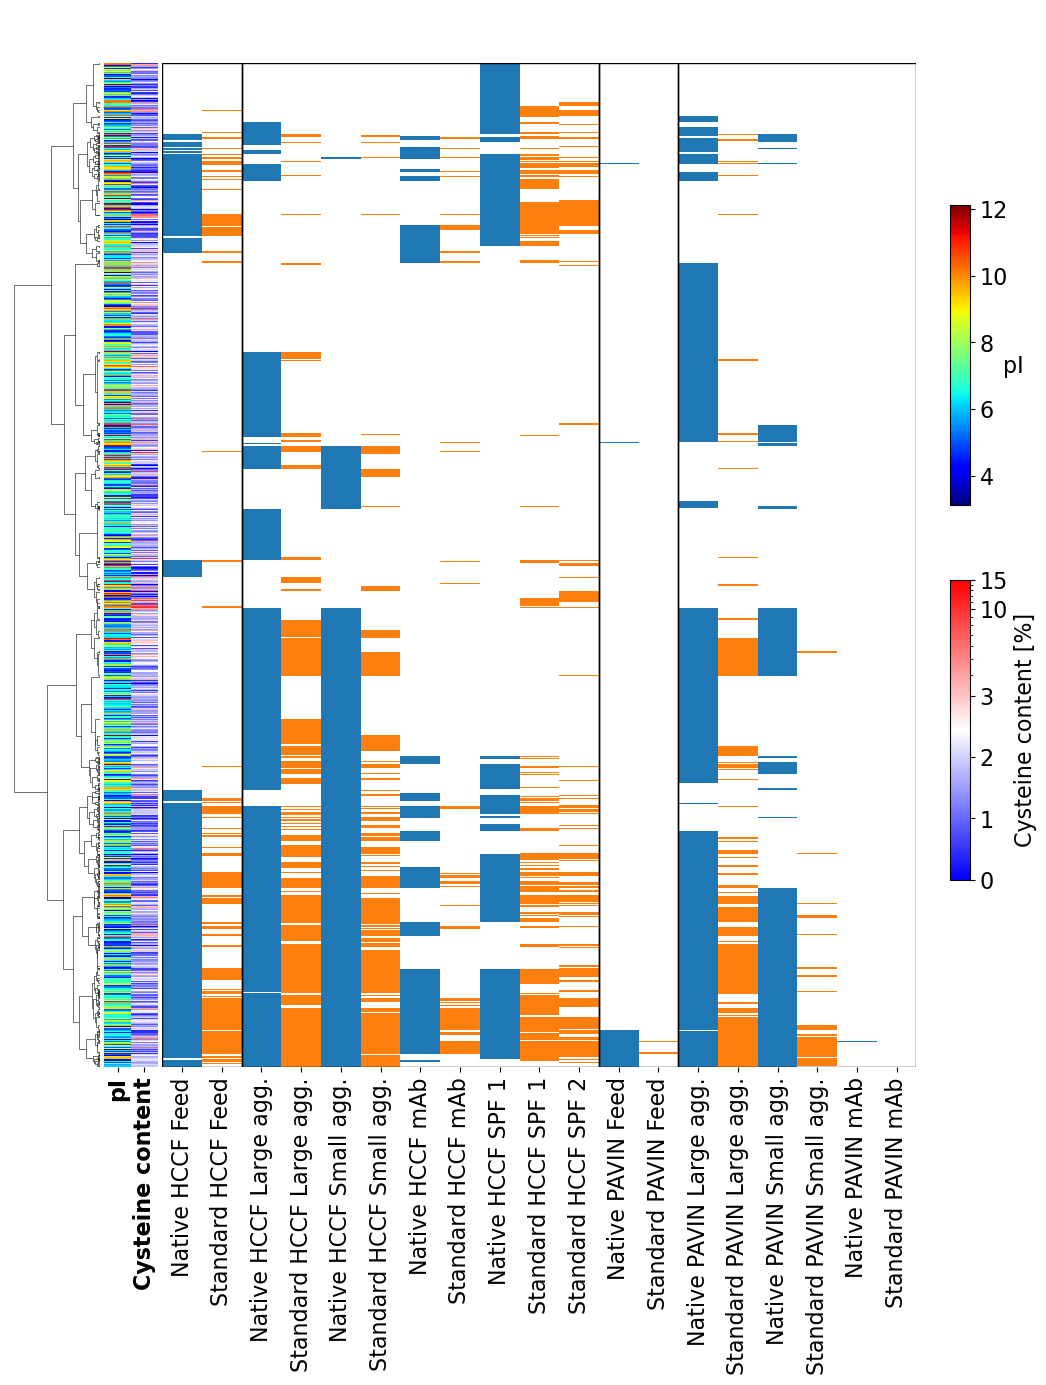

In [20]:
ax = sns.clustermap(df_locs_2, row_colors=row_colors, cmap=cmap_cluster, norm=norm_cluster, method='ward',
                    cbar_pos=None, dendrogram_ratio=(0.1, 0.05), figsize=(10, 15), yticklabels=False, col_cluster=False)

fontsize = 16
rotation = 90

# Set row color label 
ax_row_colors = ax.ax_row_colors
ax_row_colors.set_xticklabels(ax_row_colors.get_xmajorticklabels(), rotation=rotation, ha='right', rotation_mode='anchor', va='center', fontsize=fontsize, weight='bold')

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', va='center', rotation_mode='anchor', fontsize=fontsize)
real_ax.set_ylabel(None)

# Color bars
cbar_ax = ax.fig.add_axes([0.97, 0.65, 0.02, 0.2])
cbar = matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
cbar.set_label(series.name, fontsize=fontsize, rotation=0)
cbar.ax.tick_params(labelsize=fontsize)

cbar_ax2 = ax.fig.add_axes([0.97, 0.4, 0.02, 0.2])
cbar2 = matplotlib.colorbar.ColorbarBase(cbar_ax2, cmap=cmap2, norm=norm2)
cbar2.set_label(series2.name, fontsize=fontsize, rotation=90)
cbar2.ax.tick_params(labelsize=fontsize)
ticks = [0, 1, 2, 3, 10, 15]
cbar2.set_ticks(ticks, labels=[f'{i}' for i in ticks])
cbar2.set_ticks([i for i in range(15) if i not in ticks], minor=True)

heat = ax.ax_heatmap
r = heat.add_patch(Rectangle((0, 0), 2, len(df_locs_2), fill=False, edgecolor='black', lw=1))
r = heat.add_patch(Rectangle((2, 0), 9, len(df_locs_2), fill=False, edgecolor='black', lw=1))
r = heat.add_patch(Rectangle((11, 0), 2, len(df_locs_2), fill=False, edgecolor='black', lw=1))
r = heat.add_patch(Rectangle((13, 0), 6, len(df_locs_2), fill=False, edgecolor='black', lw=1))

# ax.savefig(f'./images/2_clustermap_native_and_standard.png', dpi=300)
# ax.savefig(f'./images/2_clustermap_native_and_standard.eps', dpi=300)
# ax.savefig(f'./images/2_clustermap_native_and_standard.tif', dpi=300)

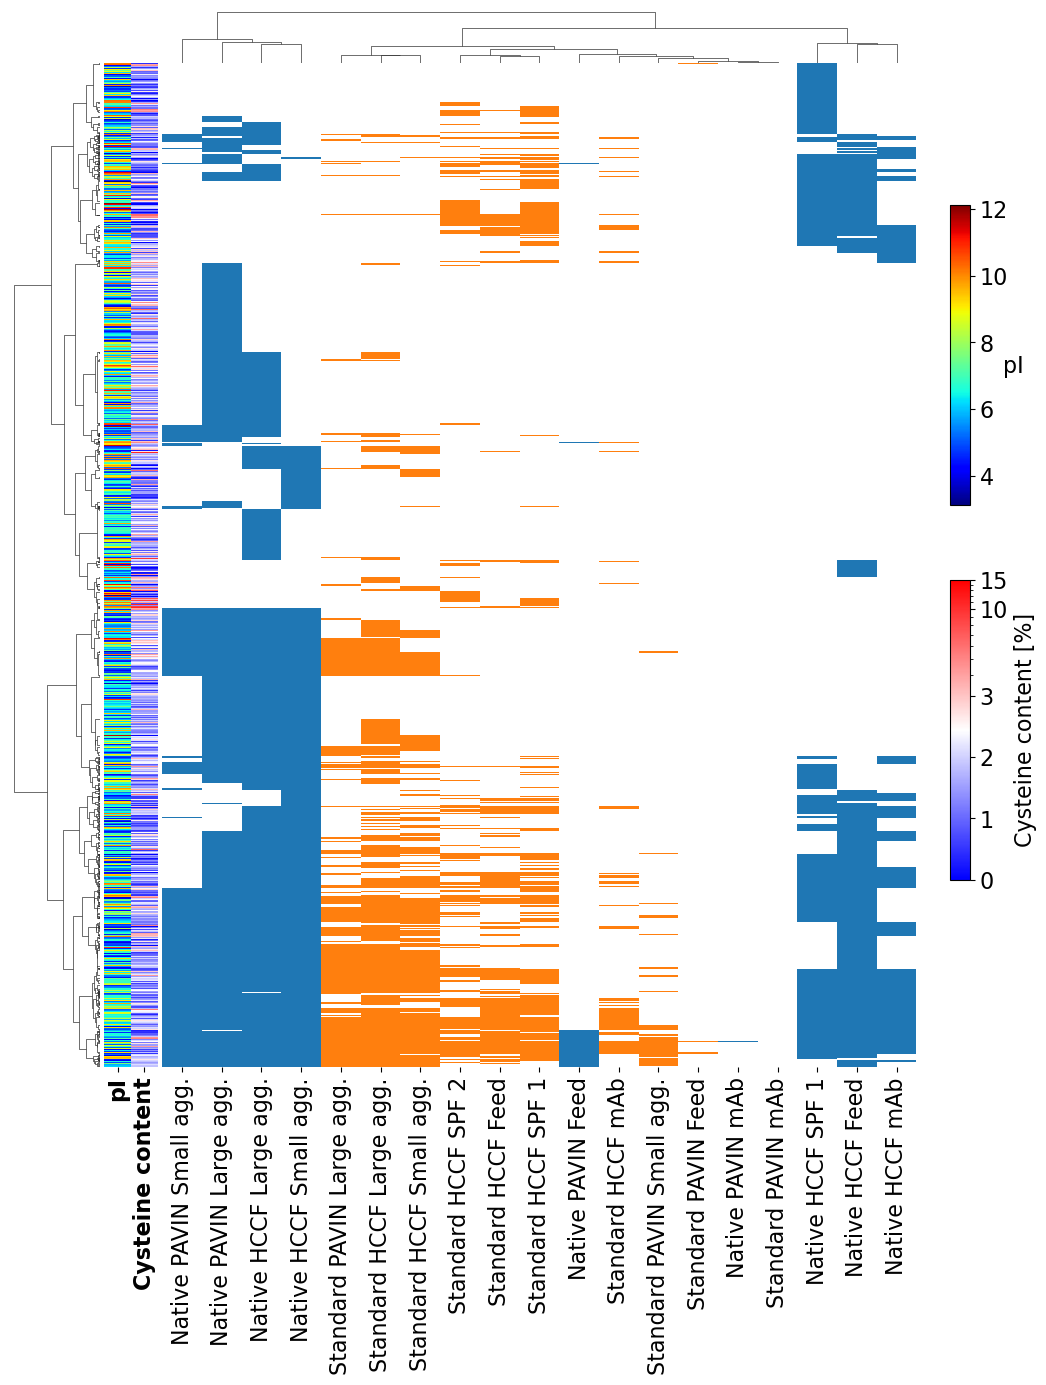

In [20]:
ax = sns.clustermap(df_locs_2, row_colors=row_colors, cmap=cmap_cluster, norm=norm_cluster, method='ward',
                    cbar_pos=None, dendrogram_ratio=(0.1, 0.05), figsize=(10, 15), yticklabels=False)

fontsize = 16
rotation = 90

# Set row color label 
ax_row_colors = ax.ax_row_colors
ax_row_colors.set_xticklabels(ax_row_colors.get_xmajorticklabels(), rotation=rotation, ha='right', rotation_mode='anchor', va='center', fontsize=fontsize, weight='bold')

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', va='center', rotation_mode='anchor', fontsize=fontsize)
real_ax.set_ylabel(None)

# Color bars
cbar_ax = ax.fig.add_axes([0.97, 0.65, 0.02, 0.2])
cbar = matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
cbar.set_label(series.name, fontsize=fontsize, rotation=0)
cbar.ax.tick_params(labelsize=fontsize)

cbar_ax2 = ax.fig.add_axes([0.97, 0.4, 0.02, 0.2])
cbar2 = matplotlib.colorbar.ColorbarBase(cbar_ax2, cmap=cmap2, norm=norm2)
cbar2.set_label(series2.name, fontsize=fontsize, rotation=90)
cbar2.ax.tick_params(labelsize=fontsize)
ticks = [0, 1, 2, 3, 10, 15]
cbar2.set_ticks(ticks, labels=[f'{i}' for i in ticks])
cbar2.set_ticks([i for i in range(15) if i not in ticks], minor=True)

# ax.savefig(f'./images/2_clustermap_native_and_standard_column_clustered.png', dpi=300)

In [21]:
def keyword_clustermap(keyword, df_master, df_locs_2, names=False, row_cluster=True, ysize=10, xsize=16, yticklabels=True, name_fontsize=16):
    if names is False:
        names = [name for name in df_locs_2.index if keyword in name.lower() and 'binding' not in name.lower()] 
    
    df_master_3 = df_master.loc[names].copy()
    df_locs_3 = df_locs_2.loc[names].copy()
    
    cmap_cluster = matplotlib.colors.ListedColormap(['white', 'tab:orange', 'tab:blue'])
    norm_cluster = BoundaryNorm([0, 0.25, 0.75, 1], cmap_cluster.N)

    series = df_master['pI']
    cmap = plt.get_cmap('jet')
    norm = plt.Normalize(series.min(), series.max())
    row_colors1 = cmap(norm(series))

    series2 = df_master['Cysteine content [%]']
    cmap2 = plt.get_cmap('bwr')
    norm2 = colors.SymLogNorm(3.0)
    row_colors2 = cmap2(norm2(series2))

    row_colors = pd.concat([pd.Series(row_colors1.tolist(), index=df_master.index, name='pI'), 
                            pd.Series(row_colors2.tolist(), index=df_master.index, name='Cysteine content')], axis=1)

    ax = sns.clustermap(df_locs_3, row_colors=row_colors, cmap=cmap_cluster, norm=norm_cluster, row_cluster=row_cluster,
                        cbar_pos=None, dendrogram_ratio=(0.07, 0.05), figsize=(xsize, ysize), yticklabels=yticklabels, col_cluster=False, method='ward')

    fontsize = 16
    rotation = 90
    
    # Set row color label 
    ax_row_colors = ax.ax_row_colors
    ax_row_colors.set_xticklabels(ax_row_colors.get_xmajorticklabels(), rotation=rotation, ha='right', rotation_mode='anchor', va='center', fontsize=fontsize, weight='bold')

    real_ax = ax.ax_heatmap
    real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', rotation_mode='anchor', va='center', fontsize=fontsize)
    real_ax.set_yticklabels(real_ax.get_ymajorticklabels(), fontsize=name_fontsize)
    real_ax.set_ylabel(None)

    cbar_ax = ax.fig.add_axes([-0.05, 0.65, 0.02, 0.2])
    cbar = matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cbar.set_label(series.name, fontsize=fontsize, rotation=0)
    cbar.ax.tick_params(labelsize=fontsize)
    
    cbar_ax2 = ax.fig.add_axes([-0.05, 0.4, 0.02, 0.2])
    cbar2 = matplotlib.colorbar.ColorbarBase(cbar_ax2, cmap=cmap2, norm=norm2)
    cbar2.set_label(series2.name, fontsize=fontsize, rotation=90)
    cbar2.ax.tick_params(labelsize=fontsize)
    ticks = [0, 1, 2, 3, 10, 15]
    cbar2.set_ticks(ticks, labels=[f'{i}' for i in ticks])
    cbar2.set_ticks([i for i in range(15) if i not in ticks], minor=True)

    heat = ax.ax_heatmap
    r = heat.add_patch(Rectangle((0, 0), 2, len(df_locs_3), fill=False, edgecolor='black', lw=1))
    r = heat.add_patch(Rectangle((2, 0), 9, len(df_locs_3), fill=False, edgecolor='black', lw=1))
    r = heat.add_patch(Rectangle((11, 0), 2, len(df_locs_3), fill=False, edgecolor='black', lw=1))
    r = heat.add_patch(Rectangle((13, 0), 6, len(df_locs_3), fill=False, edgecolor='black', lw=1))
        
    return ax

In [22]:
proteases = [name for name in df_locs_2.index if 'protease' in name.lower() and 'binding' not in name.lower()]
proteases.sort()
proteinases = [name for name in df_locs_2.index if 'proteinase' in name.lower() and 'binding' not in name.lower()]
proteinases.sort()
cathepsins = [name for name in df_locs_2.index if 'cathepsin' in name.lower() and 'binding' not in name.lower()]
cathepsins.sort()
peptidases = [name for name in df_locs_2.index if 'peptidase' in name.lower() and 'binding' not in name.lower()]
peptidases.sort()
proteasomes = [name for name in df_locs_2.index if 'proteasome' in name.lower() and 'binding' not in name.lower() and 'chaperone' not in name.lower()]
proteasomes.sort()
all_proteases = proteases + proteinases + cathepsins + peptidases + proteasomes
assert(len(all_proteases) == len([*set(all_proteases)]))

lipases = [name for name in df_locs_2.index if 'lipase' in name.lower() and 'binding' not in name.lower()]
lipases.sort()
phsopholipases = [name for name in df_locs_2.index if 'phsopholipase' in name.lower() and 'binding' not in name.lower()]
phsopholipases.sort()
hydrolases = [name for name in df_locs_2.index if 'hydrolase' in name.lower() and 'binding' not in name.lower()]
hydrolases.sort()
esterases = [name for name in df_locs_2.index if 'esterase' in name.lower() and 'binding' not in name.lower()]
esterases.sort()
all_lipases_temp = lipases + hydrolases + esterases
all_lipases = []
for n in all_lipases_temp:
    if n not in all_lipases:
        all_lipases.append(n)
assert(len(all_lipases) == len([*set(all_lipases)]))

glucosidases = [name for name in df_locs_2.index if 'cosidase' in name.lower() and 'binding' not in name.lower()] 
glucosidases.sort()
galactosidases = [name for name in df_locs_2.index if 'galactosidase' in name.lower() and 'binding' not in name.lower()] 
galactosidases.sort()
glucuronidases = [name for name in df_locs_2.index if 'glucuronidase' in name.lower() and 'binding' not in name.lower()] 
glucuronidases.sort()
mannosidases = [name for name in df_locs_2.index if 'mannosidase' in name.lower() and 'binding' not in name.lower()] 
mannosidases.sort()
fucosidases = [name for name in df_locs_2.index if 'fucosidase' in name.lower() and 'binding' not in name.lower()] 
fucosidases.sort()
sialidases = [name for name in df_locs_2.index if 'sialidase' in name.lower() and 'binding' not in name.lower()] 
sialidases.sort()
all_glucosidases_temp = glucosidases + galactosidases + glucuronidases + mannosidases + fucosidases + sialidases
all_glucosidases = []
for n in all_glucosidases_temp:
    if n not in all_glucosidases:
        all_glucosidases.append(n)
assert(len(all_glucosidases) == len([*set(all_glucosidases)]))

histones = [
 'Histone H1.2',
 'Histone H1.3',
 'Core histone macro-H2A.1 isoform X9',
 'Histone H2B type 1',
 'Nucleosome assembly protein 1-like 1 isoform X3',
 'Nucleosome assembly protein 1-like 4 isoform X2']

ribosomes = [name for name in df_locs_2.index if 'ribosom' in name.lower() and 'binding' not in name.lower() and 'transferase' not in name.lower()] 
ribosomes.sort()

heat_shock = [name for name in df_locs_2.index if 'heat shock' in name.lower() and 'binding' not in name.lower()] 
heat_shock.sort()

chaperones = [name for name in df_locs_2.index if 'chaperone' in name.lower() and 'regulator' not in name.lower()] 
chaperones.sort()

peroxiredoxins = [name for name in df_locs_2.index if 'peroxiredoxin' in name.lower() and 'binding' not in name.lower()] 
peroxiredoxins.sort()

glutathiones = [name for name in df_locs_2.index if 'glutathione s-transferase' in name.lower() and 'binding' not in name.lower()] 
glutathiones.sort()

actins = [name for name in df_locs_2.index if 'actin' in name.lower() and 'interacting' not in name.lower()] 
actins.sort()

ubiquitins = [name for name in df_locs_2.index if 'ubiquitin' in name.lower() and 'receptor' not in name.lower()] 
ubiquitins.sort()

protein_lists = [all_proteases, all_glucosidases, all_lipases, histones, ribosomes, heat_shock, chaperones, peroxiredoxins, actins, glutathiones]
combined = []
for l in protein_lists:
    combined += l
assert(len(combined) == len([*set(combined)]))

In [23]:
sorted_names = []
sorted_protein_lists = []
for l in protein_lists:
    df_temp = df_master.loc[l].copy()
    df_temp.sort_values(by=['Native HCCF Feed', 'Standard HCCF Feed', 'Native HCCF Large agg.', 'Standard HCCF Large agg.', 
                         'Native HCCF Small agg.', 'Standard HCCF Small agg.',                     
                         'Native PAVIN Feed', 'Standard PAVIN Feed', 'Native PAVIN Large agg.', 'Standard PAVIN Large agg.', 
                         'Native PAVIN Small agg.', 'Standard PAVIN Small agg.', 
                         'Native HCCF mAb', 'Standard HCCF mAb', 'Native HCCF SPF 1', 'Standard HCCF SPF 1', 'Standard HCCF SPF 2',   
                         'Native PAVIN mAb', 'Standard PAVIN mAb'], inplace=True, ascending=False)
    for n in df_temp.index:
        sorted_names.append(n)
    sorted_protein_lists.append(list(df_temp.index))

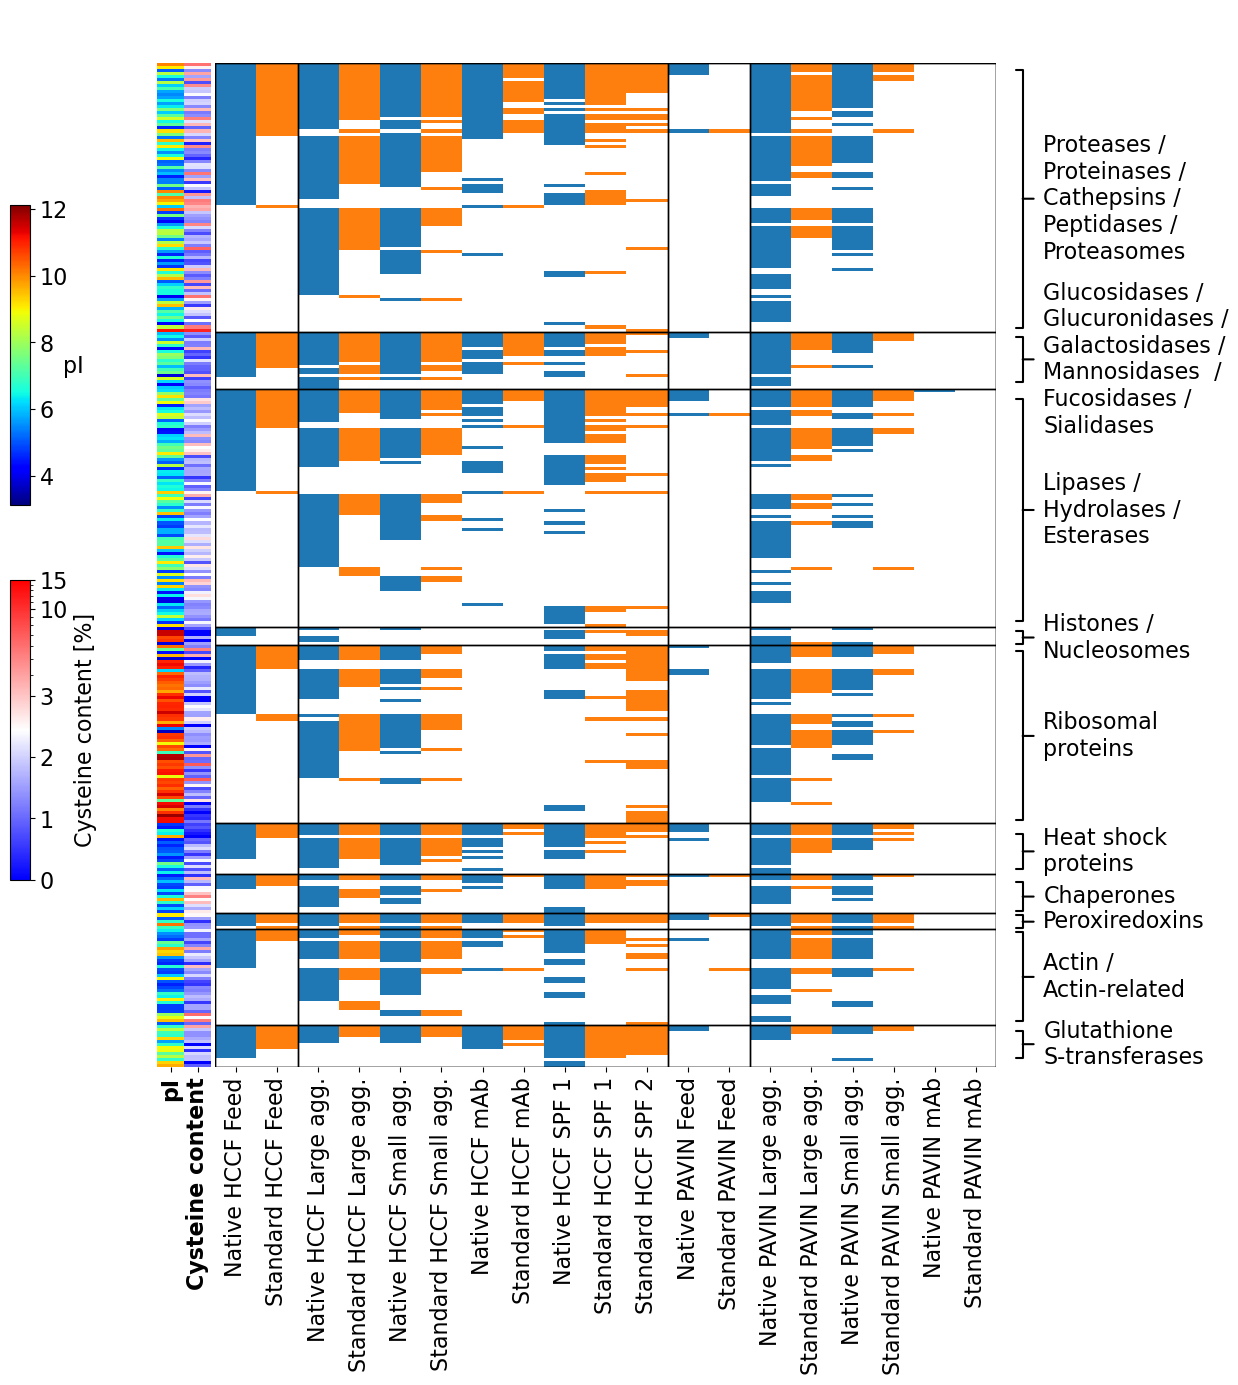

In [25]:
ax = keyword_clustermap(keyword=None, df_master=df_master, df_locs_2=df_locs_2, names=sorted_names, row_cluster=False, xsize=10, ysize=15, yticklabels=False)
heat = ax.ax_heatmap
cnt = 0
for protein_list in protein_lists:
    r = heat.add_patch(Rectangle((0, cnt), 19, len(protein_list), fill=False, edgecolor='black', lw=1))
    cnt += len(protein_list)
    
text_1 = heat.annotate('Proteases /\nProteinases /\nCathepsins /\nPeptidases /\nProteasomes', xy=(1.03, 0.865), xytext=(1.06, 0.865), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=5.8, lengthB=0.3', lw=1.5), fontsize=16, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

text_1 = heat.annotate('Glucosidases /\nGlucuronidases /\nGalactosidases /\nMannosidases  /\nFucosidases /\nSialidases', 
                       xy=(1.03, 0.705), xytext=(1.06, 0.705), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=1, lengthB=0.3', lw=1.5), fontsize=16, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

text_1 = heat.annotate('Lipases /\nHydrolases /\nEsterases', xy=(1.03, 0.555), xytext=(1.06, 0.555), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=0.3', lw=1.5), fontsize=16, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

text_1 = heat.annotate('Histones /\nNucleosomes', xy=(1.03, 0.428), xytext=(1.06, 0.428), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=0.3, lengthB=0.3', lw=1.5), fontsize=16, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

text_1 = heat.annotate('Ribosomal\nproteins', xy=(1.03, 0.33), xytext=(1.06, 0.33), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=3.8, lengthB=0.3', lw=1.5), fontsize=16, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

text_1 = heat.annotate('Heat shock\nproteins', xy=(1.03, 0.215), xytext=(1.06, 0.215), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=0.8, lengthB=0.3', lw=1.5), fontsize=16, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

text_1 = heat.annotate('Chaperones', xy=(1.03, 0.17), xytext=(1.06, 0.17), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=0.65, lengthB=0.3', lw=1.5), fontsize=16, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

text_1 = heat.annotate('Peroxiredoxins', xy=(1.03, 0.145), xytext=(1.06, 0.145), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=0.3, lengthB=0.3', lw=1.5), fontsize=16, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

text_1 = heat.annotate('Actin /\nActin-related', xy=(1.03, 0.09), xytext=(1.06, 0.09), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=0.3', lw=1.5), fontsize=16, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

text_1 = heat.annotate('Glutathione\nS-transferases', xy=(1.03, 0.017 + 0.006), xytext=(1.06, 0.017 + 0.006), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=0.6, lengthB=0.3', lw=1.5), fontsize=16, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

# plt.savefig('./images/2_sorted_heatmap_HCP_families.png', dpi=300, bbox_inches='tight')
# plt.savefig('./images/2_sorted_heatmap_HCP_families.tif', dpi=300, bbox_inches='tight')
# plt.savefig('./images/2_sorted_heatmap_HCP_families.eps', dpi=300, bbox_inches='tight')

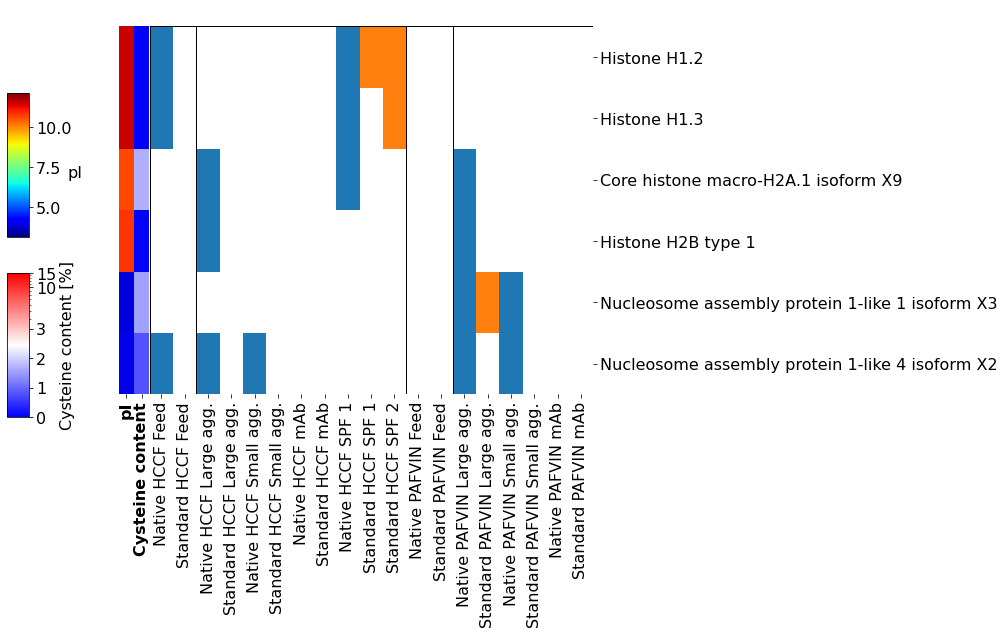

In [15]:
keyword_clustermap(keyword=None, df_master=df_master, df_locs_2=df_locs_2, names=histones, row_cluster=False, xsize=15, ysize=10, yticklabels=True)